### Check Hardware & RAM availability:

Commands to check for available GPU and RAM allocation on runtime

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec  1 13:12:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:07:00.0 Off |                    0 |
| N/A   35C    P0              55W / 400W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 1082.0 gigabytes of available RAM



### References:
* https://huggingface.co/
* https://arxiv.org/abs/1907.11692

### Install Required Libraries for Transformer Models:

* Pre-Trained Transformer models are part of Hugging Face Library(transformers).
* Similarly, any datatset part of Hugging Face can be called from the **datasets** library.
* Finally we will use a high level abstraction package called **k-train** to simplify our modelling and predictions

In [3]:
!pip install ktrain
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 16.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for fastprogress>=0.1.21 from https://files.pythonhosted.org/packages/a7/8f/213223fdee199c55db81e2d0c669f30e8285c5be2526c4ed924de39247da/fastprogress-1.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 18.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for chardet from https://files.pythonhosted.org/packages/38/6f/f5fbc992a329ee4e0f288c1fe0e2ad9485ed064cac731ed2fe47dcc38cbf/chardet-5.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for syntok>1.3.3 from https://files.pythonhosted.org/packages/47/0d/e9700408c99275692c57ac786edfbede03cf2a9818bd3ecbc4cbf21a4448/syntok-1.4.4-py3-none-any.whl

### Import Libraries:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from datasets import list_datasets
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import timeit
import warnings

pd.set_option('display.max_columns', None)
warnings.simplefilter(action="ignore")

### Load Emotion Dataset:

In [6]:
emotion_train = load_dataset('emotion', split='train')
emotion_val = load_dataset('emotion', split='validation')
emotion_test = load_dataset('emotion', split='test')
print("Details for Emotion Train Dataset: ", emotion_train.shape)
print("Details for Emotion Validation Dataset: ", emotion_val.shape)
print("Details for Emotion Test Dataset: ", emotion_test.shape)

Details for Emotion Train Dataset:  (16000, 2)
Details for Emotion Validation Dataset:  (2000, 2)
Details for Emotion Test Dataset:  (2000, 2)


In [7]:
print("\nTrain Dataset Features for Emotion: \n", emotion_train.features)
print("\nTest Dataset Features for Emotion: \n", emotion_val.features)
print("\nTest Dataset Features for Emotion: \n", emotion_test.features)


Train Dataset Features for Emotion: 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Test Dataset Features for Emotion: 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Test Dataset Features for Emotion: 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


### Create DataFrame object:

For modelling, it is required to convert the dataset object into a dataframe object

In [8]:
emotion_train_df = pd.DataFrame(data=emotion_train)
emotion_val_df = pd.DataFrame(data=emotion_val)

In [9]:
class_label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### Instantiating a RoBERTa Instance:

Create a RoBERTa instance with the model name, max token length, the labels to be used for each category and the batch size.

In [10]:
roberta_transformer = text.Transformer('roberta-base', maxlen=512, classes=class_label_names, batch_size=6)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Split Train & Validation data:

In [11]:
X_train = emotion_train_df[:]["text"]
y_train = emotion_train_df[:]["label"]
X_test = emotion_val_df[:]["text"]
y_test = emotion_val_df[:]["label"]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16000,) (16000,) (2000,) (2000,)


### Perform Data Preprocessing:

In [12]:
roberta_train = roberta_transformer.preprocess_train(X_train.to_list(), y_train.to_list())
roberta_val = roberta_transformer.preprocess_test(X_test.to_list(), y_test.to_list())

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 52


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 40
	99percentile : 52


### Compile RoBERTa in a K-Train Learner Object:

Since we are using k-train as a high level abstration package, we need to wrap our model in a k-train Learner Object for further compuation

In [13]:
roberta_model = roberta_transformer.get_classifier()

In [14]:
roberta_learner_ins = ktrain.get_learner(model=roberta_model,
                            train_data=roberta_train,
                            val_data=roberta_val,
                            batch_size=6)

### RoBERTa Model Details:

In [15]:
roberta_learner_ins.model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  595206    
 ificationHead)                                                  
                                                                 
Total params: 124650246 (475.50 MB)
Trainable params: 124650246 (475.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Find Optimal Learning Rate for RoBERTa:

This is an optional step used just to show how the learning rate can be found for any transformer model.
For Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2666/2666 [==============================] - 473s 171ms/step - loss: 1.1560 - accuracy: 0.5754
Epoch 2/3
2666/2666 [==============================] - 458s 172ms/step - loss: 1.9526 - accuracy: 0.3907
Epoch 3/3
2666/2666 [==============================] - 0s 49us/step - loss: 27.0234 - accuracy: 0.0000e+00


done.
Visually inspect loss plot and select learning rate associated with falling loss


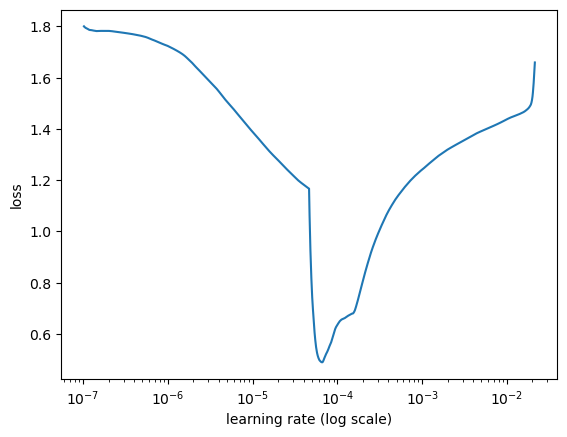


Total time in minutes on estimating optimal learning rate: 
 15.585189787916413


In [16]:
rate_finder_start_time = timeit.default_timer()
roberta_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

### RoBERTa Optimal Learning Rates:

As per the evaluations made in the research paper "**RoBERTa: A Robustly Optimized BERT Pretraining Approach**", below are the best choices in terms of fine-tuning the model:

* Batch Sizes => {16, 32}
* Learning Rates => {1e−5, 2e−5, 3e−5}

We will choose the maximum among these for our fine-tuning and evaluation purposes.

### Fine Tuning RoBERTa on Emotion Dataset:

We take our emotion dataset along with the RoBERTa model, define the learning-rate & epochs to be used and start fine-tuning.

In [17]:
roberta_fine_tune_start_time = timeit.default_timer()
roberta_learner_ins.fit_onecycle(lr=3e-5, epochs=3)
roberta_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: \n", (roberta_fine_tune_stop_time - roberta_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/3
2667/2667 [==============================] - 472s 172ms/step - loss: 0.4828 - accuracy: 0.8332 - val_loss: 0.2006 - val_accuracy: 0.9250
Epoch 2/3
2667/2667 [==============================] - 457s 172ms/step - loss: 0.2016 - accuracy: 0.9210 - val_loss: 0.1347 - val_accuracy: 0.9305
Epoch 3/3
2667/2667 [==============================] - 458s 172ms/step - loss: 0.1122 - accuracy: 0.9427 - val_loss: 0.1043 - val_accuracy: 0.9465

Total time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: 
 23.533963503066722


### Checking RoBERTa performance metrics:

In [18]:
roberta_learner_ins.validate()

63/63 [==============================] - 5s 47ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       550
           1       0.97      0.96      0.96       704
           2       0.86      0.90      0.88       178
           3       0.93      0.95      0.94       275
           4       0.93      0.89      0.91       212
           5       0.87      0.89      0.88        81

    accuracy                           0.95      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       0.95      0.95      0.95      2000



array([[534,   0,   0,  10,   6,   0],
       [  0, 675,  24,   2,   0,   3],
       [  0,  17, 161,   0,   0,   0],
       [  4,   3,   2, 262,   4,   0],
       [  7,   0,   0,   8, 189,   8],
       [  1,   3,   0,   0,   5,  72]])

In [19]:
roberta_learner_ins.validate(class_names=class_label_names)

63/63 [==============================] - 3s 45ms/step
              precision    recall  f1-score   support

     sadness       0.98      0.97      0.97       550
         joy       0.97      0.96      0.96       704
        love       0.86      0.90      0.88       178
       anger       0.93      0.95      0.94       275
        fear       0.93      0.89      0.91       212
    surprise       0.87      0.89      0.88        81

    accuracy                           0.95      2000
   macro avg       0.92      0.93      0.92      2000
weighted avg       0.95      0.95      0.95      2000



array([[534,   0,   0,  10,   6,   0],
       [  0, 675,  24,   2,   0,   3],
       [  0,  17, 161,   0,   0,   0],
       [  4,   3,   2, 262,   4,   0],
       [  7,   0,   0,   8, 189,   8],
       [  1,   3,   0,   0,   5,  72]])

In [19]:
roberta_learner_ins.view_top_losses(preproc=roberta_transformer)

----------
id:1124 | loss:7.75 | true:anger | pred:sadness)

----------
id:1683 | loss:7.09 | true:anger | pred:joy)

----------
id:1046 | loss:7.07 | true:sadness | pred:fear)

----------
id:415 | loss:5.24 | true:love | pred:joy)



### Saving RoBERTa Model:

In [20]:
roberta_predictor = ktrain.get_predictor(roberta_learner_ins.model, preproc=roberta_transformer)
roberta_predictor.get_classes()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [22]:
roberta_predictor.save('roberta-emotion-predictor')

In [23]:
!zip -r roberta-emotion-predictor roberta-emotion-predictor

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: roberta-emotion-predictor/ (stored 0%)
  adding: roberta-emotion-predictor/merges.txt (deflated 53%)
  adding: roberta-emotion-predictor/special_tokens_map.json (deflated 52%)
  adding: roberta-emotion-predictor/tf_model.h5 (deflated 14%)
  adding: roberta-emotion-predictor/tf_model.preproc (deflated 47%)
  adding: roberta-emotion-predictor/tokenizer_config.json (deflated 76%)
  adding: roberta-emotion-predictor/config.json (deflated 54%)
  adding: roberta-emotion-predictor/tokenizer.json (deflated 72%)
  adding: roberta-emotion-predictor/vocab.json (deflated 59%)


### Loading Saved Model for New Predictions:

In [24]:
roberta_predictor_new = ktrain.load_predictor('roberta-emotion-predictor')
roberta_predictor_new.get_classes()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### Load Test data split:

In [25]:
emotion_test_df = pd.DataFrame(data=emotion_test)
print("\nShape of Test Dataset: ", emotion_test_df.shape,"\n\n")
emotion_test_df.head()


Shape of Test Dataset:  (2000, 2) 




,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [26]:
emotion_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


### Modify dataframe for label mis-match:

In [27]:
label_dict = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
emotion_test_df["label"] = emotion_test_df["label"].map(label_dict)
emotion_test_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [28]:
emotion_test_df[emotion_test_df.columns] = emotion_test_df[emotion_test_df.columns].astype(str)

### Use test data as new prediction data:

In [29]:
X_test_new = emotion_test_df[:]["text"]
y_test_new = emotion_test_df[:]["label"]
print(X_test_new.shape, y_test_new.shape)

(2000,) (2000,)


In [30]:
test_predictions = roberta_predictor_new.predict(X_test_new.to_list())

### View Performance Metrics on new test data:

In [31]:
print(confusion_matrix(y_test_new, test_predictions))

[[263   7   2   0   3   0]
 [  7 193   0   0   5  19]
 [  2   0 660  27   2   4]
 [  0   0  24 135   0   0]
 [ 17   5   1   1 557   0]
 [  0  10   4   0   1  51]]


In [32]:
print(classification_report(y_test_new, test_predictions))

              precision    recall  f1-score   support

       anger       0.91      0.96      0.93       275
        fear       0.90      0.86      0.88       224
         joy       0.96      0.95      0.95       695
        love       0.83      0.85      0.84       159
     sadness       0.98      0.96      0.97       581
    surprise       0.69      0.77      0.73        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



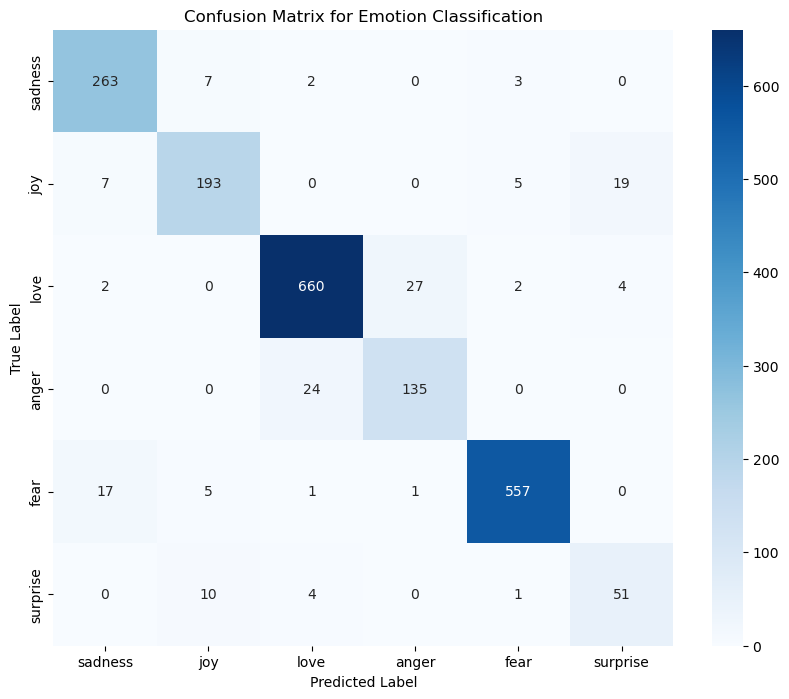

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix data
cm = np.array([
    [263, 7, 2, 0, 3, 0],
    [7, 193, 0, 0, 5, 19],
    [2, 0, 660, 27, 2, 4],
    [0, 0, 24, 135, 0, 0],
    [17, 5, 1, 1, 557, 0],
    [0, 10, 4, 0, 1, 51]
])


# Class labels
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)

# Add title and labels
plt.title('Confusion Matrix for Emotion Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
